### Transfer learning using MobileNetV3
In the field of machine learning, transfer learning is a powerful technique that leverages pre-trained models and applies them to new tasks. This approach allows us to save time and computational resources by reusing the knowledge gained from training on large datasets.

In this exercise we use MobileNetV3, a convolutional neural network architecture for mobile devices, to train a classifier for the Fashion-MNIST dataset using the PyTorch framework.

Fashion-MNIST is a drop-in replacement for MNIST (images of size 28x28 with 10 classes) but instead of hand-written digits it contains tiny images of clothes!

Steps
- Load the Fashion-MNIST dataset using the torchvision package.
- Define a PyTorch model using the MobileNetV3 architecture.
- Train the model on the Fashion-MNIST dataset.
- Evaluate the model on the test set.

In [23]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

### 1: Load the Fashion-MNIST dataset
The torchvision package provides access to popular datasets, model architectures, and image transformations for computer vision.

In [5]:
# Load the fashion-MNIST dataset
def load_data(batch_size, data_die="../data/"):
    # load the fashion-MNIST dataset
    # define the transformer to normalize the data
    transformer = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    # download and load the training data
    trainset = datasets.FashionMNIST(
        data_die, download=True, train=True, transform=transformer
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )
    # download and load the test data
    testset = datasets.FashionMNIST(
        data_die, download=True, train=False, transform=transformer
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False
    )
    return trainloader, testloader


# trainloader, testloader = load_data(64)
trainloader, testloader = load_data(64)

100%|██████████| 26.4M/26.4M [00:39<00:00, 675kB/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:06<00:00, 633kB/s] 


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.09MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [15]:
# define helper function to help with the label
def get_class_names():
    """Return the list of classes in the Fashion-MNIST dataset"""
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]


def get_class_name(class_index):
    """Return the class name for a given index"""
    return get_class_names()[class_index]


def get_class_index(class_name):
    """Return the class index for a given name"""
    return get_class_name().index(class_name)


def get_class_count():
    """Return the number of classes in the Fashion-MNIST dataset"""
    return len(get_class_name())


# get the class name for the first image in the training set
for class_index in range(10):
    class_index = class_index
    class_name = get_class_name(class_index)
    print(f"class_index:{class_index}, class_name:{class_name}")

class_index:0, class_name:T-shirt/top
class_index:1, class_name:Trouser
class_index:2, class_name:Pullover
class_index:3, class_name:Dress
class_index:4, class_name:Coat
class_index:5, class_name:Sandal
class_index:6, class_name:Shirt
class_index:7, class_name:Sneaker
class_index:8, class_name:Bag
class_index:9, class_name:Ankle boot


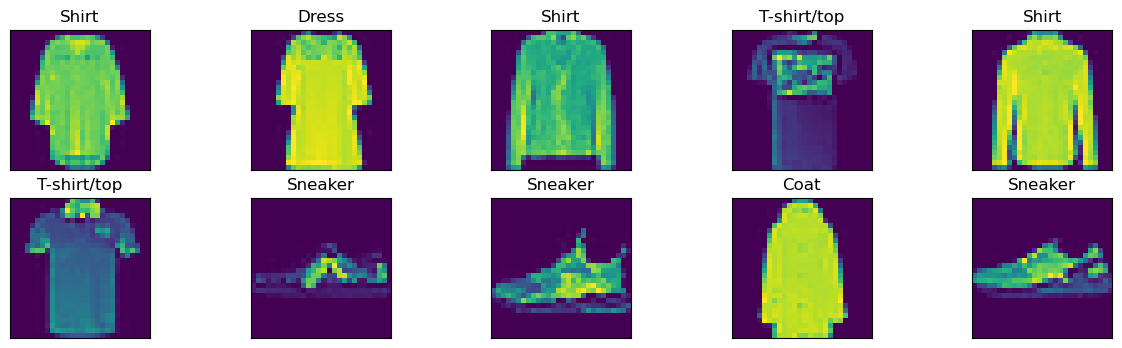

In [25]:
def imshow(img):
    """Display the image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert from tensor to numpy array
    plt.imshow(
        np.transpose(npimg, (1, 2, 0))
    )  # transpose the array to be in the format (height, width, channels)


image, labels = next(iter(trainloader))  # get the first batch of images
# show the images with labels
fig = plt.figure(figsize=(15, 4))
plot_size = 10
for idx in range(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    imshow(image[idx])
    ax.set_title(get_class_name(int(labels[idx].item())))

### 2. Define a PyTorch model using the MobileNetV3 architecture.
The torchvision.models.mobilenet_v3_large class provides access to pre-trained MobileNetV3 model. We can use the model and replace the final layer with a fully-connected layer with 10 outputs since we have 10 classes. We can then freeze the weights of the convolutional layers and train only the new fully-connected layer.

Let's start with inspecting the original MobileNetV3 (small version) first:

In [22]:
# Load a pre-trained MobileNetV3 and inspect its structure

mobilenet_v3_model = models.mobilenet_v3_small(pretrained=True)
print(mobilenet_v3_model)

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/Aaron/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:13<00:00, 781kB/s] 

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [43]:
# define  a model class that extends the nn.Module class
class MobileNetV3(nn.Module):
    def __init__(self):
        super(MobileNetV3, self).__init__()
        # load the pre-trained MobileNetV3 model
        self.model = models.mobilenet_v3_small(pretrained=True)
        # Get the number of features for the last layer in the classifier
        # num_features = self.model.classifier[-1].in_features
        # Replace the last fully-connected layer with a new one of the right size
        self.model.classifier[3] = nn.Linear(1024, 10)
        # Freeze all the weights of the network except for the last fully-connected layer
        self.freeze()

    def forward(self, x):
        # convert 1X28X28 inpit tensor  to 3X28X28, to convert grayscale to RGB
        x = x.repeat(1, 3, 1, 1)  # convert grayscale to RGB
        # resixe the input tensor to 224X224 since MobileNetV3 (Small) expects images of that size
        if x.shape[2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        # forwars pass
        return self.model(x)

    def freeze(self):
        # freeze all the layers in the model
        for param in self.model.parameters():
            param.requires_grad = False
        # unfreeze the last layer
        for param in self.model.classifier[3].parameters():
            param.requires_grad = True

    def unfreeze(self):
        # unfreeze all the layers in the model
        for param in self.model.parameters():
            param.requires_grad = True

In [44]:
# Create an instance of the MobileNetV3 model
model = MobileNetV3()
print(model)

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

### 3. Train the model on the MNIST dataset
We can train the model using the standard PyTorch training loop. For the loss function, we'll use CrossEntropyLoss. We also use the Adam optimizer with a learning rate of 0.002. We train the model for 1 epoch so we can see how the model performs after just one pass of the training data.

In [45]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

Now let's choose our device automatically (CPU, GPU, or MPS) and write our training loop!

The MPS backend is for M1/M2/etc Macs.

If you are having any errors running the code locally, you should try to use the cpu mode manually, i.e. device = torch.device("cpu")

In [46]:
# Set the device as GPU, MPS, or CPU according to availability
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [47]:
model = model.to(device)  # move the model to the device
epochs = 1
for epoch in range(epochs):
    for batch_num, (images, labels) in enumerate(trainloader):
        # move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        # calculate the loss
        loss = loss_function(outputs, labels)
        # backward pass
        loss.backward()
        # optimize the weights
        optimizer.step()
        # print statistics
        if (batch_num) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, epochs, batch_num + 1, len(trainloader), loss.item()
                )
            )

Epoch [1/1], Batch [1/938], Loss: 2.2921
Epoch [1/1], Batch [101/938], Loss: 0.4582
Epoch [1/1], Batch [201/938], Loss: 0.4769
Epoch [1/1], Batch [301/938], Loss: 0.3152
Epoch [1/1], Batch [401/938], Loss: 0.4534
Epoch [1/1], Batch [501/938], Loss: 0.4320
Epoch [1/1], Batch [601/938], Loss: 0.4165
Epoch [1/1], Batch [701/938], Loss: 0.4386
Epoch [1/1], Batch [801/938], Loss: 0.3193
Epoch [1/1], Batch [901/938], Loss: 0.3839


### 4. Evaluate the model on the test set
We evaluate the model on the test set by:

- printing the accuracy
- plotting a few examples of correct and incorrect predictions.

In [50]:
correct = 0
total = 0
loss = 0
for images, labels in testloader:
    # move the images and labels to the device
    images = images.to(device)
    labels = labels.to(device)
    # forward pass
    outputs = model(images)
    loss += loss_function(outputs, labels).item()
    # torch.max return max amd argmax. We are interested in the argmax
    _, predicted = torch.max(outputs, 1)
    # Compute the accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
print('Test Loss of the model on the 10000 test images: {}'.format(loss / total))

Test Accuracy of the model on the 10000 test images: 85.48 %
Test Loss of the model on the 10000 test images: 0.006394163388013839


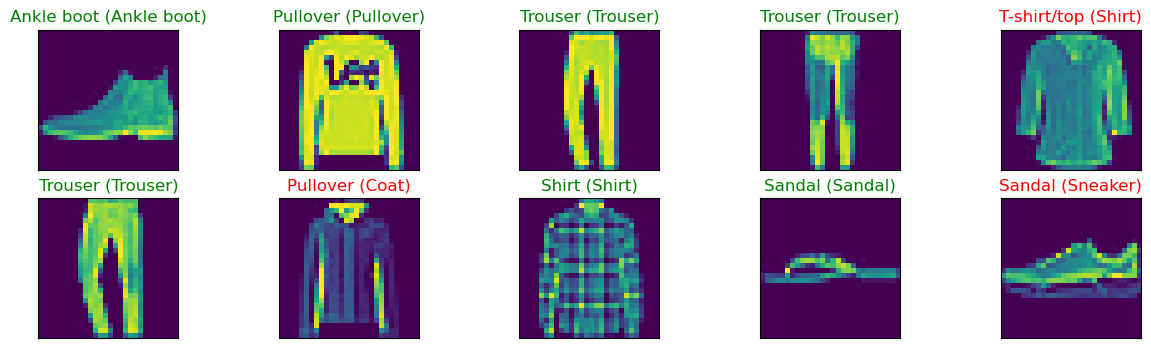

In [49]:
# Get the first batch of images and labels
images, labels = next(iter(testloader))

# Move tensors to the configured device
images = images.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

# Plot the images with labels, at most 10
fig = plt.figure(figsize=(15, 4))

for idx in np.arange(min(10, len(images))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images.cpu()[idx]))
    ax.set_title(
        "{} ({})".format(get_class_name(predicted[idx]), get_class_name(labels[idx])),
        color=("green" if predicted[idx] == labels[idx] else "red"),
    )